# 1. Introduction 
The notebook is dedicated to develop **product recommendar system** for H&M based on data from previous transactions, as well as from customer and product (articles) meta data. This will help customers make the right choices and enhance the shopping experience.

There are different kinds of data that help us to get our recommender system:
* **images** - image corresponding to each `article_id`
* **articles** - detailed metadata for each `article_id` available for purchase
* **customers** - metadata for each `customer_id`
* **transactions_train** -  the training data, consisting of the purchases each customer for each date, as well as additional information.

## 1.1 Library Setup and Load the Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import gc
from matplotlib import pyplot as plt

In [2]:
# helper
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pickle as pkl

def convert_c_id(series, dictionary):
    """map customer id to int, this will reduce the memory usage by 16x"""
    return series.map(dictionary).astype('int32')

def a_id_str_to_int(series):
    """map article id to int, this will reduce the memory usage by 2.5x"""
    return series.astype('int32')

def a_id_int_to_str(series):
    """convert back to original article id for submission"""
    return '0' + series.astype('str')

def codes_cat(series):
    """reduce data memory by converting categorical obj to int"""
    return pd.Series(pd.Categorical(series, categories=series.dropna().unique()).codes)

# 2. Exploration

## 2.1 `articles`

In [3]:
articles = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv")

In [4]:
articles['article_id'] = articles['article_id'].astype('int32')
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [5]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int32 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

This table contains all H&M articles with details such as product, appearance, index and other features. Total 25 columns and `detail_desc` column have missing values.  

In [6]:
articles.duplicated().sum()

0

**There is no duplicates in articles.** (0 is the number duplicate row).

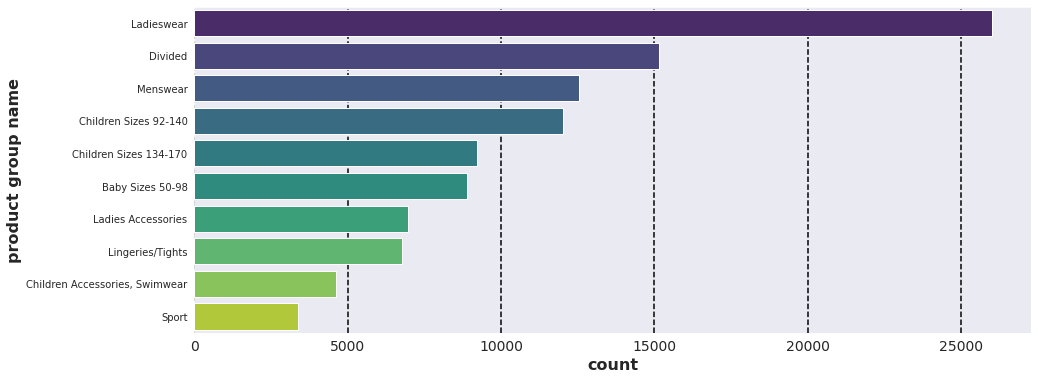

In [7]:
sns.set_style("darkgrid")
# f, ax = plt.subplots(figsize=(12, 6))
# ax = sns.countplot(data=articles, 
#                    y='index_name',
#                    order=articles['index_name'].value_counts().index,
#                    color='yellow')
# ax.set_xlabel('count')
# ax.set_ylabel('index name')
# plt.show()
# ////////////
f, ax = plt.subplots(figsize=(15, 6))
ax = sns.barplot(data=articles.groupby('index_name')['article_id'].count().rename('tot_count') \
                      .reset_index().sort_values(by='tot_count', ascending=False),
                  x='tot_count',
                  y='index_name',
                  palette='viridis')
ax.set_xlabel('count', fontweight='bold', fontsize=16)
ax.set_ylabel('product group name', fontweight='bold', fontsize=16)

# ax.set_xscale('log')
ax.tick_params(axis='x', labelsize=14)
plt.grid(axis="x",color = 'black', linestyle = '--', linewidth = 1.5)
plt.show()

**Ladieswear accounts for a significant part of all dresses. Sport has the least portion.**


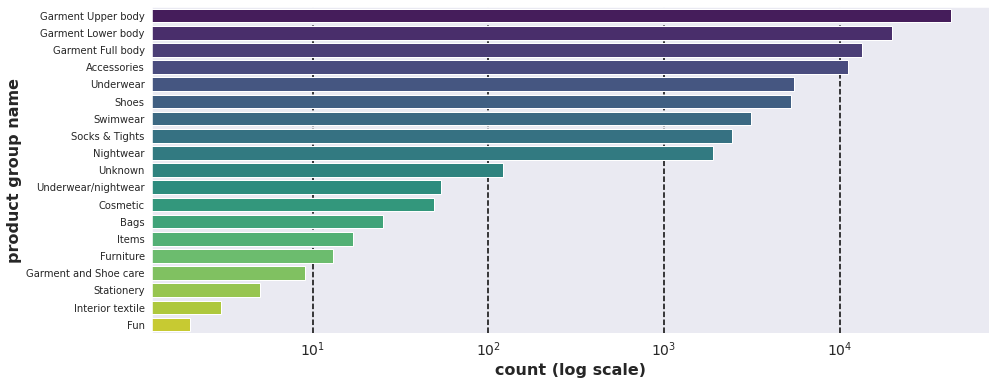

In [8]:
f, ax = plt.subplots(figsize=(15, 6))
ax = sns.barplot(data=articles.groupby('product_group_name')['article_id'].count().rename('tot_count') \
                      .reset_index().sort_values(by='tot_count', ascending=False),
                  x='tot_count',
                  y='product_group_name',
                  palette='viridis')
ax.set_xlabel('count (log scale)', fontweight='bold', fontsize=16)
ax.set_ylabel('product group name', fontweight='bold', fontsize=16)

ax.set_xscale('log')
ax.tick_params(axis='x', labelsize=14)
plt.grid(axis="x",color = 'black', linestyle = '--', linewidth = 1.5)
plt.show()

**Garment is the most in demand product sold.**

Let's take a look at `product_type_name` and `product_group_name`.

In [9]:
pd.options.display.max_rows = None
articles.groupby(['product_group_name', 'product_type_name']).count()['article_id']

product_group_name     product_type_name       
Accessories            Accessories set                 7
                       Alice band                      6
                       Baby Bib                        3
                       Bag                          1280
                       Beanie                         56
                       Belt                          458
                       Bracelet                      180
                       Braces                          3
                       Bucket hat                      7
                       Cap                            13
                       Cap/peaked                    573
                       Dog Wear                       20
                       Earring                      1159
                       Earrings                       11
                       Eyeglasses                      2
                       Felt hat                       10
                       Giftbox          

**Accessories are really various, the most numerious: bags, earrings and hats. However, bags itself is another product group name.**

**There is duplicate category for** `Underwear/nightwear`, `Underwear`, **and** `Nightwear`. **I think** `Underwear/nightwear` **should be associate with** `Nigthwear` **instead.** Let's fix this issue.

In [10]:
articles.loc[(articles['product_group_name'] == 'Underwear/nightwear'),'product_group_name'] = 'Nightwear'
articles['product_group_name'].unique()

array(['Garment Upper body', 'Underwear', 'Socks & Tights',
       'Garment Lower body', 'Accessories', 'Items', 'Nightwear',
       'Unknown', 'Shoes', 'Swimwear', 'Garment Full body', 'Cosmetic',
       'Interior textile', 'Bags', 'Furniture', 'Garment and Shoe care',
       'Fun', 'Stationery'], dtype=object)

In [11]:
articles.groupby(['index_group_name', 'index_name']).count()['article_id']

index_group_name  index_name                    
Baby/Children     Baby Sizes 50-98                   8875
                  Children Accessories, Swimwear     4615
                  Children Sizes 134-170             9214
                  Children Sizes 92-140             12007
Divided           Divided                           15149
Ladieswear        Ladies Accessories                 6961
                  Ladieswear                        26001
                  Lingeries/Tights                   6775
Menswear          Menswear                          12553
Sport             Sport                              3392
Name: article_id, dtype: int64

**Pay attention to index group-index structure.** `Ladieswear` **and** `Children/Baby` **have subgroups.**

## 2.2 `customers`

In [12]:
customers = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/customers.csv")

id_to_index_dict = dict(zip(customers["customer_id"], customers.index))
index_to_id_dict = dict(zip(customers.index, customers["customer_id"]))

# for memory efficiency
customers["customer_id"] = customers["customer_id"].map(id_to_index_dict)

In [13]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,0,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,1,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,2,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,3,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,4,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [14]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  int64  
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 73.3+ MB


**There are 7 columns and several of them have missing values.**

In [15]:
customers.isnull().sum()

customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16009
age                        15861
postal_code                    0
dtype: int64

In [16]:
customers.nunique()

customer_id               1371980
FN                              1
Active                          1
club_member_status              3
fashion_news_frequency          4
age                            84
postal_code                352899
dtype: int64

**There is no duplicates in customers.** (1371980 entries and 1371980 unique value customer_id).

`FN` and `Active` 1 or missed.

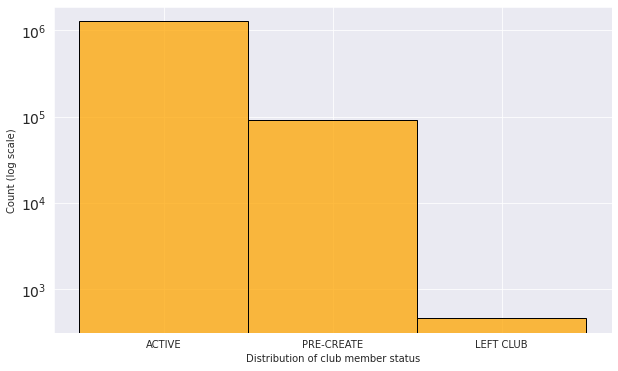

In [17]:
f, ax = plt.subplots(figsize=(10,6))
ax = sns.histplot(data=customers, x='club_member_status', color='orange', edgecolor='black')
ax.set_yscale('log')

ax.set_xlabel('Distribution of club member status')
ax.set_ylabel('Count (log scale)')
ax.tick_params(axis='y', labelsize=14)

plt.show()

**Status in H&M club. Almost every customer has an active club status, some of them begin to activate it (pre-create). A tiny part of customers abandoned the club.**

In [18]:
customers['fashion_news_frequency'].unique()

array(['NONE', 'Regularly', nan, 'Monthly', 'None'], dtype=object)

There is *inconsistent* values for None data in `fashion_news_frequency`. Let's fix this issue.

In [19]:
customers.loc[~customers['fashion_news_frequency'].isin(['Regularly', 'Monthly']), 'fashion_news_frequency'] = None
customers['fashion_news_frequency'].unique()

array([None, 'Regularly', 'Monthly'], dtype=object)

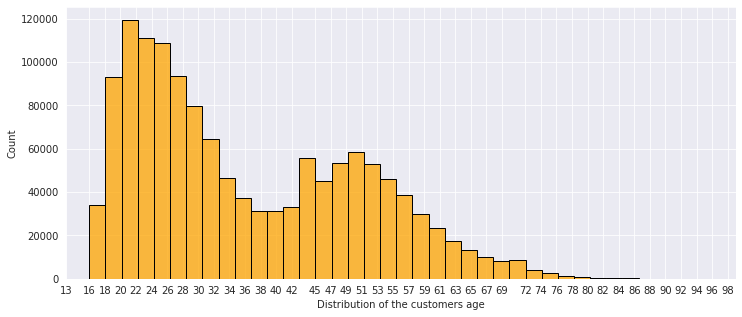

In [20]:
min_val = customers.age.min()
max_val = customers.age.max()
val_width = max_val - min_val
n_bins = 40
bin_width = (val_width/n_bins)

f, ax = plt.subplots(figsize=(12,5))
ax = sns.histplot(data=customers, x='age', bins=n_bins, color='orange', edgecolor='black')
ax.set_xlabel('Distribution of the customers age')

plt.xlim(min_val, max_val)
plt.xticks(np.arange(min_val-bin_width, max_val+bin_width, bin_width).astype(int))
plt.show()

**The most common age is around 20-24.** The distribution of the age feature is bivariate. In order to create more effective plots, we will create a categorical column for age which divides the ages in age groups.

In [21]:
customers['age_groups'] = pd.cut(customers['age'], bins=[16, 20, 30, 40,50, 60, 70, float('Inf')], labels=['16-20', '20-30','30-40','40-50','50-60','60-70' , '70+'])

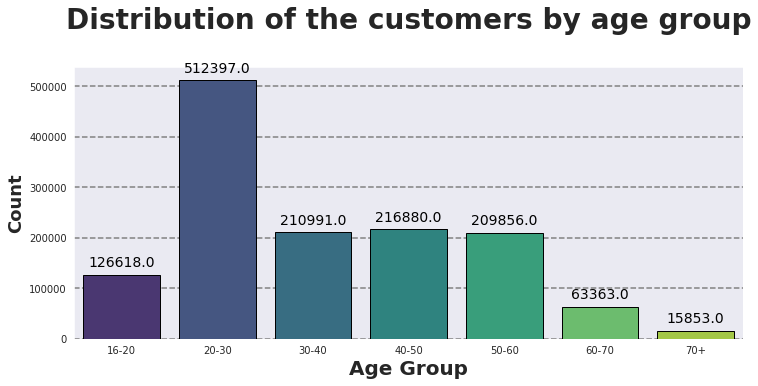

In [22]:
plt.figure(figsize=(12,5))
plt.title("Distribution of the customers by age group\n", fontweight="bold", size=28)
g = sns.barplot(x="age_groups", y="count", data=customers.groupby('age_groups')['customer_id'].count().rename('count') \
                .reset_index(), palette="viridis", edgecolor="black")
plt.xlabel("Age Group",fontweight="bold", size=20)
plt.ylabel("Count",fontweight="bold", size=18)
for container in g.containers:
    g.bar_label(container, padding = 5, fmt='%.1f', fontsize=14, color="black")
plt.grid(axis="y",color = 'grey', linestyle = '--', linewidth = 1.5)
plt.show()


In [23]:
pd.options.display.max_rows = 20
customers['postal_code'].value_counts()

2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c    120303
cc4ed85e30f4977dae47662ddc468cd2eec11472de6fac5ec985080fd92243c8       261
714976379549eb90aae4a71bca6c7402cc646ae7c40f6c1cb91d4b5a18623fc1       159
7c1fa3b0ec1d37ce2c3f34f63bd792f3b4494f324b6be5d1e4ba6a75456b96a7       157
5b7eb31eabebd3277de632b82267286d847fd5d44287ee150bb4206b48439145       156
                                                                     ...  
16dd7e391f305b54c01ffed87c189e33de83158d0a808d1b346222703742f638         1
5ce1c699380b3c13655347c9636043f5e64ec2538a1ee7d42dd253a584577630         1
afdedc642d01efeefec6fc8d3394724a71888ebd0ff0311eff6f34946589479d         1
4c8838d278d23029c920b9684fa4cf30a532428a445afb300eeb288685cf00e1         1
0a1a03306fb2f62164c2a439b38c0caa64b40deaae868799ccb93ac69444b79d         1
Name: postal_code, Length: 352899, dtype: int64

**Here we have abnormal number of customers by one postal code. One has 120303, it might be encoded for nan adress.**

## 2.3 `transactions`

In [24]:
transactions = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv",
                          parse_dates=["t_dat"])

# for memory efficiency
transactions["customer_id"] = transactions["customer_id"].map(id_to_index_dict)
transactions["customer_id"] = transactions["customer_id"].astype('int32')

# for switching back for submission
# sub["customer_id"] = sub["customer_id"].map(index_to_id_dict)

In [25]:
transactions.tail()

,t_dat,customer_id,article_id,price,sales_channel_id
31788319,2020-09-22,1371691,929511001,0.059305,2
31788320,2020-09-22,1371691,891322004,0.042356,2
31788321,2020-09-22,1371721,918325001,0.043203,1
31788322,2020-09-22,1371747,833459002,0.006763,1
31788323,2020-09-22,1371960,898573003,0.033881,2


In [26]:
import math
import numpy as np
from datetime import timedelta

pd_dates = pd.to_datetime(transactions['t_dat'])
unique_dates = pd.Series(pd_dates.unique())
numbered_days = unique_dates - unique_dates.min() + timedelta(1)
numbered_days = numbered_days.dt.days
extra_days = numbered_days.max() % 7
numbered_days -= extra_days
day_weeks = (numbered_days / 7).apply(lambda x: math.ceil(x))

day_weeks_map = pd.DataFrame(
    {"day_weeks": day_weeks, "unique_dates": unique_dates}
).set_index("unique_dates")["day_weeks"]

all_day_weeks = pd_dates.map(day_weeks_map)
all_day_weeks = all_day_weeks.astype("int8")

transactions['week'] = all_day_weeks

In [27]:
unique_dates = transactions['t_dat'].unique()
unique_dates = np.sort(unique_dates)
number_range = np.arange(len(unique_dates))
date_number_dict = dict(zip(unique_dates, number_range))

all_day_numbers = transactions['t_dat'].map(date_number_dict)
all_day_numbers = all_day_numbers.astype("int16")

transactions['day'] = all_day_numbers

In [28]:
del transactions['sales_channel_id']
del transactions['t_dat']

gc.collect()

74

In [29]:
transactions.head()

,customer_id,article_id,price,week,day
0,2,663713001,0.050831,0,0
1,2,541518023,0.030492,0,0
2,7,505221004,0.015237,0,0
3,7,685687003,0.016932,0,0
4,7,685687004,0.016932,0,0


* Popular item (20) all time based on (prod_name + colorgroupname) as art_id, prod_name, index, tipe, section
* Popular item by weeks
* top pairs (n)

In [30]:
sold_qty = transactions['article_id'].value_counts()
sold_qty = sold_qty.reset_index()
sold_qty.rename(columns = {"article_id":"sold_qty","index":"article_id"}, inplace=True)
sold_qty.head()

,article_id,sold_qty
0,706016001,50287
1,706016002,35043
2,372860001,31718
3,610776002,30199
4,759871002,26329


In [31]:
from pandasql import sqldf

df_popular_item_detail = sqldf("""SELECT *
    FROM sold_qty t
    INNER JOIN articles a
    on t.article_id = a.article_id
""")

In [32]:
pd.set_option('display.max_columns', 500)
# drop duplicate column
df_popular_item_detail = df_popular_item_detail.T.drop_duplicates().T
df_popular_item_detail.head(3)

,article_id,sold_qty,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,706016001,50287,706016,Jade HW Skinny Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,9,Black,4,Dark,5,Black,1747,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,High-waisted jeans in washed superstretch deni...
1,706016002,35043,706016,Jade HW Skinny Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,71,Light Blue,3,Light,2,Blue,1747,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,High-waisted jeans in washed superstretch deni...
2,372860001,31718,372860,7p Basic Shaftless,302,Socks,Socks & Tights,1010016,Solid,9,Black,4,Dark,5,Black,3611,Shopbasket Socks,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,Fine-knit trainer socks in a soft cotton blend.


In [33]:
import gc

df_pop_art = df_popular_item_detail[['article_id', 'sold_qty']].copy()
df_pop_art['name'] = df_popular_item_detail['prod_name'] + ' ' + df_popular_item_detail['colour_group_name']

# remove df for memory 
df_top_20 = df_pop_art[0:12].copy()
del df_pop_art

gc.collect()

21

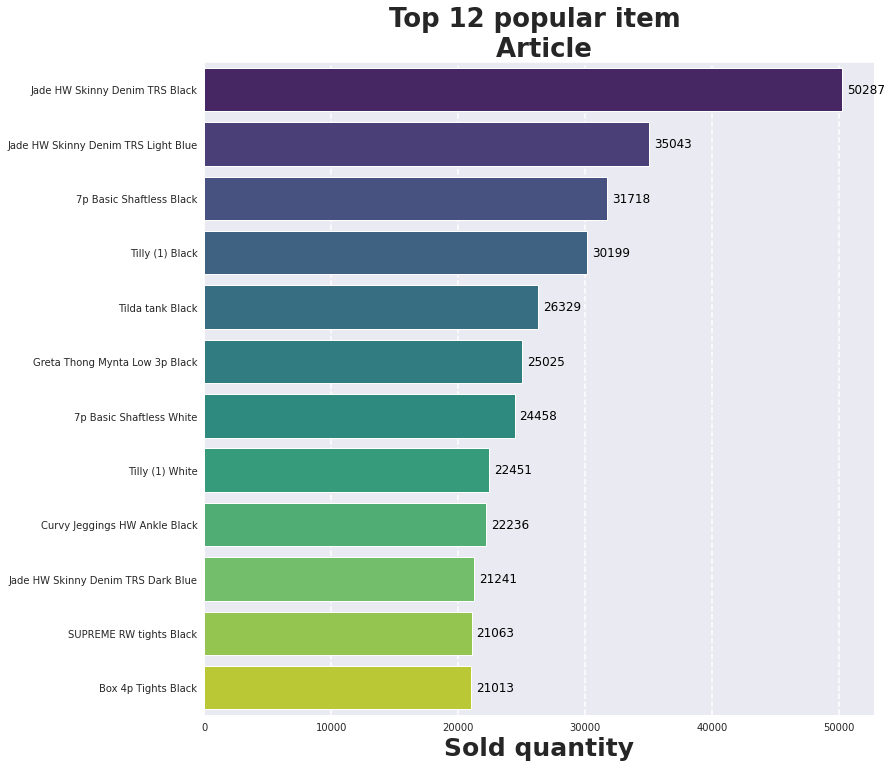

In [34]:
plt.figure(figsize=(12,12))
plt.title("Top 12 popular item \n Article", size=26, fontweight="bold")

g = sns.barplot(y="name", x="sold_qty", data=df_top_20[0:12], palette="viridis")
for container in g.containers:
    g.bar_label(container, padding = 5, fontsize=12, color='black')
plt.xlabel("Sold quantity", size=25, fontweight="bold")
plt.ylabel("")
plt.grid(axis="x",color = 'white', linestyle = '--', linewidth = 1.5)
plt.style.use('ggplot')
plt.show()

In [35]:
df_pop_prod = df_popular_item_detail[['prod_name', 'sold_qty']].copy()
df_pop_prod = df_pop_prod.groupby('prod_name')['sold_qty'].sum().reset_index().sort_values(by="sold_qty", ascending=False)

df_pop_prod_20 = df_pop_prod[0:12].copy()

del df_pop_prod
gc.collect()

3699

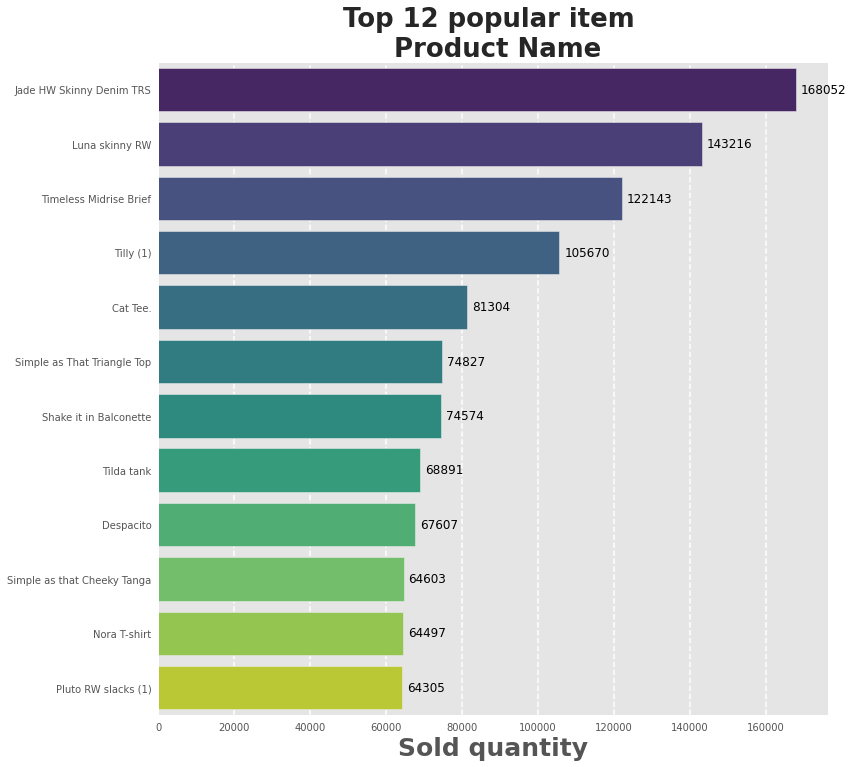

In [36]:
plt.figure(figsize=(12,12))
plt.title("Top 12 popular item \n Product Name", size=26, fontweight="bold")

g = sns.barplot(y="prod_name", x="sold_qty", data=df_pop_prod_20[0:12], palette="viridis")
for container in g.containers:
    g.bar_label(container, padding = 5, fontsize=12, color='black')
plt.xlabel("Sold quantity", size=25, fontweight="bold")
plt.ylabel("")
plt.grid(axis="x",color = 'white', linestyle = '--', linewidth = 1.5)
plt.style.use('ggplot')
plt.show()

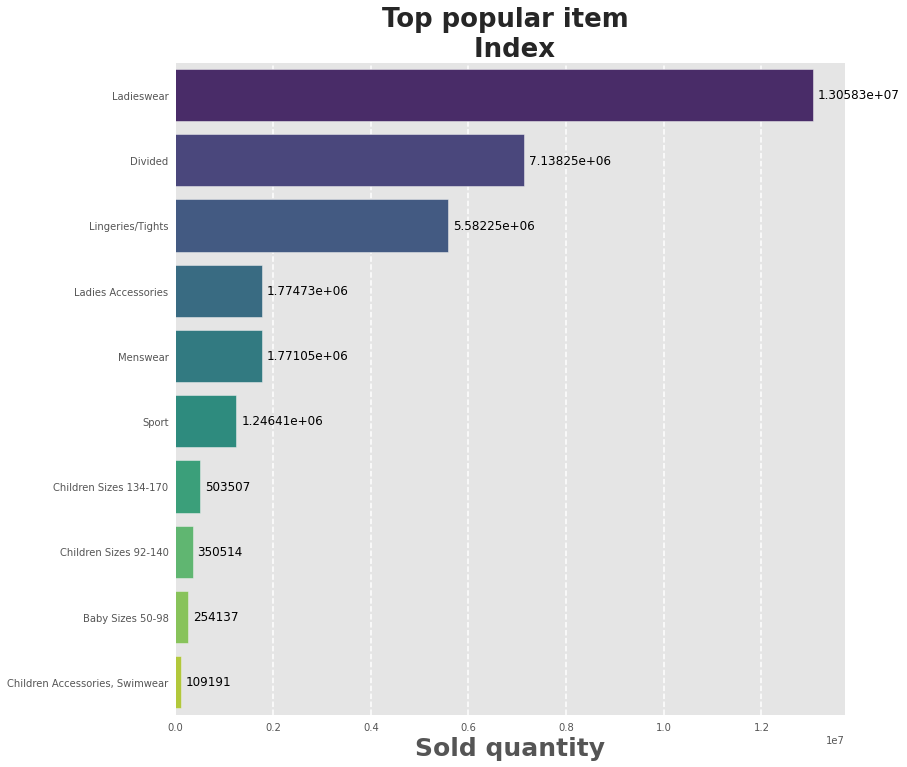

In [37]:
df_pop_index = df_popular_item_detail[['index_name', 'sold_qty']].copy()
df_pop_index = df_pop_index.groupby('index_name')['sold_qty'].sum().reset_index().sort_values(by="sold_qty", ascending=False)

plt.figure(figsize=(12,12))
plt.title("Top popular item \n Index", size=26, fontweight="bold")

g = sns.barplot(y="index_name", x="sold_qty", data=df_pop_index, palette="viridis")
for container in g.containers:
    g.bar_label(container, padding = 5, fontsize=12, color='black')
plt.xlabel("Sold quantity", size=25, fontweight="bold")
plt.ylabel("")
plt.grid(axis="x",color = 'white', linestyle = '--', linewidth = 1.5)
plt.style.use('ggplot')
plt.show()

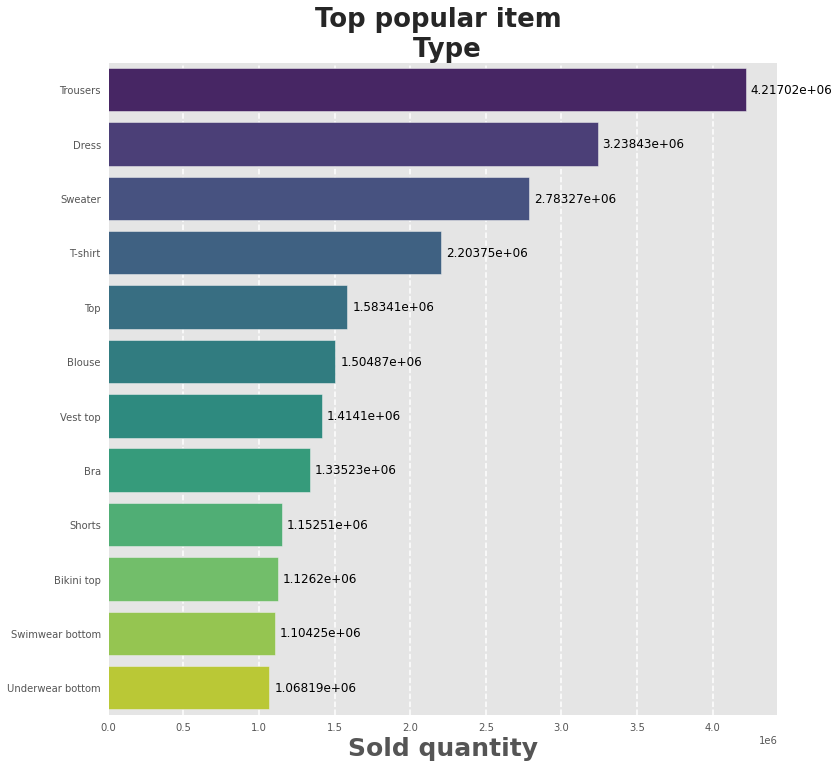

In [38]:
df_pop_type = df_popular_item_detail[['product_type_name', 'sold_qty']].copy()
df_pop_type = df_pop_type.groupby('product_type_name')['sold_qty'].sum().reset_index().sort_values(by="sold_qty", ascending=False)

df_pop_type_20 = df_pop_type[0:12].copy()
del df_pop_type
gc.collect()

plt.figure(figsize=(12,12))
plt.title("Top popular item \n Type", size=26, fontweight="bold")

g = sns.barplot(y="product_type_name", x="sold_qty", data=df_pop_type_20, palette="viridis")
for container in g.containers:
    g.bar_label(container, padding = 5, fontsize=12, color='black')
plt.xlabel("Sold quantity", size=25, fontweight="bold")
plt.ylabel("")
plt.grid(axis="x",color = 'white', linestyle = '--', linewidth = 1.5)
plt.style.use('ggplot')
plt.show()

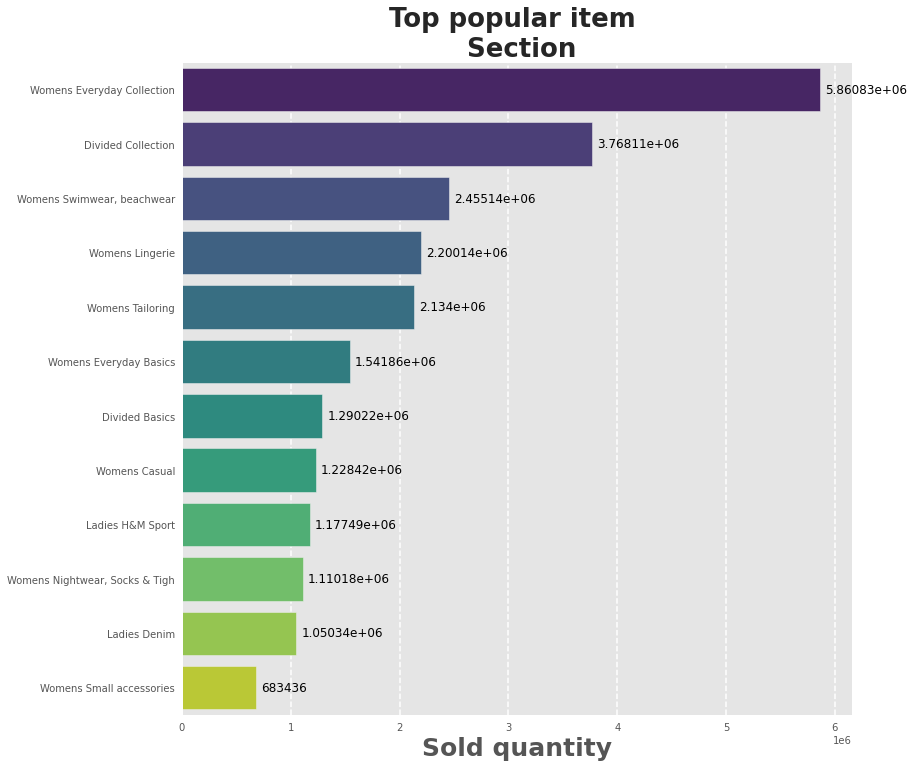

In [39]:
df_pop_sec = df_popular_item_detail[['section_name', 'sold_qty']].copy()
df_pop_sec = df_pop_sec.groupby('section_name')['sold_qty'].sum().reset_index().sort_values(by="sold_qty", ascending=False)

df_pop_sec_12 = df_pop_sec[0:12].copy()
del df_pop_sec
gc.collect()

plt.figure(figsize=(12,12))
plt.title("Top popular item \n Section", size=26, fontweight="bold")

g = sns.barplot(y="section_name", x="sold_qty", data=df_pop_sec_12, palette="viridis")
for container in g.containers:
    g.bar_label(container, padding = 5, fontsize=12, color='black')
plt.xlabel("Sold quantity", size=25, fontweight="bold")
plt.ylabel("")
plt.grid(axis="x",color = 'white', linestyle = '--', linewidth = 1.5)
plt.style.use('ggplot')
plt.show()

In [40]:
df_top_20[0:12]

,article_id,sold_qty,name
0,706016001,50287,Jade HW Skinny Denim TRS Black
1,706016002,35043,Jade HW Skinny Denim TRS Light Blue
2,372860001,31718,7p Basic Shaftless Black
3,610776002,30199,Tilly (1) Black
4,759871002,26329,Tilda tank Black
5,464297007,25025,Greta Thong Mynta Low 3p Black
6,372860002,24458,7p Basic Shaftless White
7,610776001,22451,Tilly (1) White
8,399223001,22236,Curvy Jeggings HW Ankle Black
9,706016003,21241,Jade HW Skinny Denim TRS Dark Blue


In [41]:
import os.path

# Get data
top_sold_products = df_top_20[0:12].copy()
top_sold_products['article_id'] = a_id_int_to_str(top_sold_products['article_id'])

def plot_image_samples(df, cols=1, rows=-1):
    image_path = "/kaggle/input/h-and-m-personalized-fashion-recommendations/images/"
    article_ids = df.article_id.values[0:cols*rows]
    product_names = df.name.values[0:cols*rows]
    counts = df.sold_qty.values[0:cols*rows]
    plt.figure(figsize=(2 + 3 * cols, 2 + 4 * rows))
    plt.suptitle('- Best Seller Products -', size=22, weight="bold", y=1.0)
    for i in range(cols * rows):
        article_id = article_ids[i]
        product_name = product_names[i]
        count = counts[i]
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.title(f"{product_name}\nSold quantity : {count}", size=12)
        i_path = f"{image_path}{article_id[:3]}/{article_id}.jpg"
        if os.path.isfile(i_path):
            image = Image.open(f"{image_path}{article_id[:3]}/{article_id}.jpg")
            plt.imshow(image)            
        else:
            plt.text(0.4, 0.6, "No image")
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)

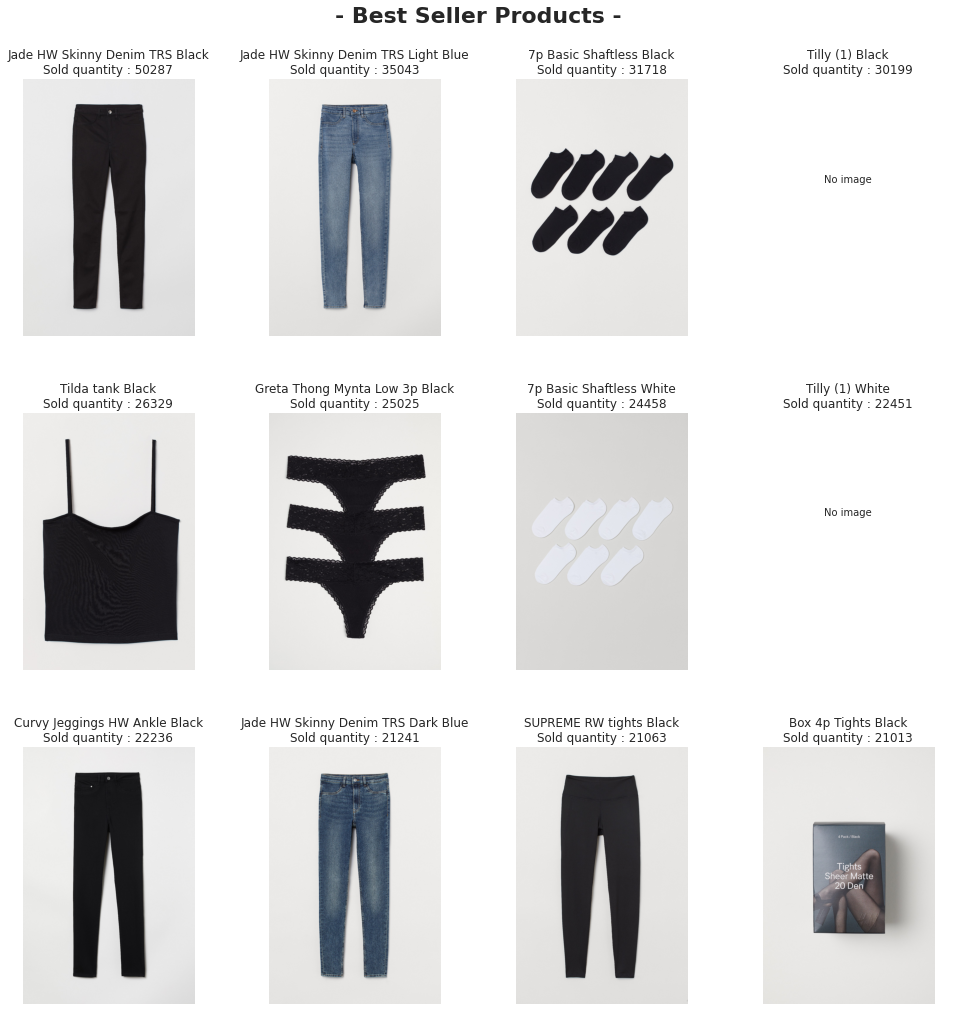

In [42]:
from PIL import Image
plot_image_samples(top_sold_products, 4, 3)